# Prediction with RNN

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Masking,Embedding
%tensorflow_version 2.x


In [2]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               train_df=None, val_df=None, test_df=None,
               label_columns=None, mean = 0, std = 1):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.mean = mean
        self.std = std

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label slice: {self.labels_slice}',
            f'Input Slice: {self.input_slice}',
            f'Label column name(s): {self.label_columns}'])
    
    def plot(self, model=None, plot_col='Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)', max_subplots=3):
        inputs, labels = self.example

        

       
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        plt.figure(figsize=(12, 3*max_n))

        inputs_denorm = (inputs*std)+mean
        labels_denorm = (labels*std[plot_col_index])+mean[plot_col_index]

        for n in range(max_n):
            plt.subplot(max_subplots, 1, n+1)
            #plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices/6, inputs_denorm[n, :, plot_col_index],
                     label='Inputs', c='#007bff')

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.plot(self.label_indices/6, labels_denorm[n, :, label_col_index], label='Labels', c='#ffc107')

            if model is not None:
                predictions = model(inputs)
                predictions_denorm = (predictions*std[plot_col_index])+mean[plot_col_index]
                plt.plot(self.label_indices/6, predictions_denorm[n, :, label_col_index],
                          label='Predictions',
                          c='#dc3545')

            if n == 0:
                plt.legend()

            plt.xticks(np.arange(0,48,2))

        
        plt.suptitle("Prediction of "+plot_col)
        plt.xlabel('Time [h]')
        plt.ylabel('Temperature [°C]')
        
   
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
        result = next(iter(self.train))
    self._example = result
    return result


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32)

  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset
WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

## Carico i dati da *eplusout.csv*

In [4]:

df=pd.read_csv('https://raw.githubusercontent.com/bre3760/ictbuilding/dev/data/eplusout.csv')
df.head()

,Date/Time,Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),Environment:Site Outdoor Air Drybulb Temperature [C](Hourly),Environment:Site Outdoor Air Dewpoint Temperature [C](TimeStep),Environment:Site Outdoor Air Dewpoint Temperature [C](Hourly),Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),Environment:Site Outdoor Air Barometric Pressure [Pa](Hourly),Environment:Site Wind Speed [m/s](TimeStep),Environment:Site Wind Speed [m/s](Hourly),Environment:Site Wind Direction [deg](TimeStep),Environment:Site Wind Direction [deg](Hourly),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),Environment:Site Direct Solar Radiation Rate per Area [W/m2](Hourly),Environment:Site Solar Azimuth Angle [deg](TimeStep),Environment:Site Solar Azimuth Angle [deg](Hourly),Environment:Site Solar Altitude Angle [deg](TimeStep),Environment:Site Solar Altitude Angle [deg](Hourly),BLOCK1:BEDROOM:Zone Total Internal Latent Gain Energy [J](TimeStep),BLOCK1:BEDROOM:Zone Total Internal Latent Gain Energy [J](Hourly),BLOCK1:BATHROOM:Zone Total Internal Latent Gain Energy [J](TimeStep),BLOCK1:BATHROOM:Zone Total Internal Latent Gain Energy [J](Hourly),BLOCK1:KITCHEN:Zone Total Internal Latent Gain Energy [J](TimeStep),BLOCK1:KITCHEN:Zone Total Internal Latent Gain Energy [J](Hourly),BLOCK1:BEDROOM:Zone People Sensible Heating Rate [W](TimeStep),BLOCK1:BEDROOM:Zone People Sensible Heating Rate [W](Hourly),BLOCK1:BATHROOM:Zone People Sensible Heating Rate [W](TimeStep),BLOCK1:BATHROOM:Zone People Sensible Heating Rate [W](Hourly),BLOCK1:KITCHEN:Zone People Sensible Heating Rate [W](TimeStep),BLOCK1:KITCHEN:Zone People Sensible Heating Rate [W](Hourly),BLOCK1:BEDROOM:Lights Total Heating Rate [W](TimeStep),BLOCK1:BEDROOM:Lights Total Heating Rate [W](Hourly),BLOCK1:BEDROOM:Zone Lights Electric Power [W](TimeStep),BLOCK1:BEDROOM:Zone Lights Electric Power [W](Hourly),BLOCK1:BATHROOM:Lights Total Heating Rate [W](TimeStep),BLOCK1:BATHROOM:Lights Total Heating Rate [W](Hourly),BLOCK1:BATHROOM:Zone Lights Electric Power [W](TimeStep),BLOCK1:BATHROOM:Zone Lights Electric Power [W](Hourly),BLOCK1:KITCHEN:Lights Total Heating Rate [W](TimeStep),...,BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Sensible Heating Rate [W](TimeStep),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Sensible Heating Rate [W](Hourly),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Total Heating Rate [W](TimeStep),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Total Heating Rate [W](Hourly),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Sensible Cooling Rate [W](TimeStep),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Sensible Cooling Rate [W](Hourly),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Total Cooling Rate [W](TimeStep),BLOCK1:BATHROOM IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Total Cooling Rate [W](Hourly),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Rate [W](TimeStep),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Heating Rate [W](Hourly),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Supply Air Sensible Cooling Rate [W](TimeStep),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Supply Air Sensible Cooling Rate [W](Hourly),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Rate [W](TimeStep),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Supply Air Total Cooling Rate [W](Hourly),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Sensible Heating Rate [W](TimeStep),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Sensible Heating Rate [W](Hourly),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Heat Recovery Total Heating Rate [W](TimeStep),BLOCK1:KITCHEN IDEAL LOADS AIR:Zone Ideal Loads Hea

In [5]:
datetimeform= []
for i in range(len(df.index)):
    tt = df["Date/Time"][i]
    days, hours = tt.split('  ')
    tt = f'{days.split("/")[1]}/{days.split("/")[0]}/2017{hours}'
    tt = tt.replace(' ', '')
    if '201724:' in tt:
        tt=tt.replace('24:', '00:')
        timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
        timestamp += 86400
        #timestamp = datetime.fromtimestamp(timestamp)
        
    else:
        timestamp = time.mktime(datetime.strptime(tt, "%d/%m/%Y%H:%M:%S").timetuple())
        #timestamp = datetime.fromtimestamp(timestamp)
    datetimeform.append(timestamp)
    
df["TimeStep"]=datetimeform

In [6]:
# Extract mean temp time series
# mean value of the 3 indoor zones
df2 = pd.DataFrame()
#"Date/Time",\
#"Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",\
#"Electricity:Facility [J](TimeStep)"
df2 = df[[
          "BLOCK1:BEDROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
          "BLOCK1:BATHROOM:Zone Mean Air Temperature [C](TimeStep:ON)",\
          "BLOCK1:KITCHEN:Zone Mean Air Temperature [C](TimeStep:ON)",\
          ]]
df3=df2.copy()
df3.dropna(inplace=True)
df3["mean"] = df3.mean(1)


df_final=pd.DataFrame()
df_final["DateTime"] = df["TimeStep"]
df_final["Outdoor_Mean"] = df["Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)"]
df_final["Indoor_Mean"] = df3["mean"]
df_final["Cooling"] = df["DistrictCooling:Facility [J](TimeStep)"]
df_final["Power"]=df["Electricity:Facility [J](TimeStep)"]
df_final["Delta_T"] = df_final["Indoor_Mean"]-df_final["Outdoor_Mean"]
#df_final

In [7]:
x = pd.DataFrame()
meas = ["TimeStep","Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)",
       "Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep)",
        "Environment:Site Wind Speed [m/s](TimeStep)",
        "Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep)",
        "Environment:Site Wind Direction [deg](TimeStep)",
       "Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep)"]

x["Indoor_Mean"] = df3["mean"]
for m in meas:
    x[m]=df[m]
#x.set_index("TimeStep",inplace=True)
#x.head()

In [8]:
column_indices = {name: i for i, name in enumerate(x.columns)}
x.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Indoor_Mean,26352.0,2.573015e+01,4.657015e-01,2.276377e+01,2.553500e+01,2.600000e+01,2.600000e+01,2.666381e+01
TimeStep,26352.0,1.498911e+09,4.564387e+06,1.491005e+09,1.494958e+09,1.498911e+09,1.502863e+09,1.506816e+09
Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep),26352.0,2.478928e+01,5.281879e+00,9.200000e+00,2.165000e+01,2.520000e+01,2.883333e+01,3.800000e+01
Environment:Site Direct Solar Radiation Rate per Area [W/m2](TimeStep),26352.0,2.968390e+02,3.410445e+02,0.000000e+00,0.000000e+00,6.066667e+01,6.813333e+02,8.610000e+02
Environment:Site Wind Speed [m/s](TimeStep),26352.0,4.090316e+00,2.647121e+00,0.000000e+00,2.066667e+00,3.350000e+00,5.700000e+00,1.390000e+01
Environment:Site Outdoor Air Barometric Pressure [Pa](TimeStep),26352.0,1.011359e+05,2.632702e+02,9.989300e+04,1.010070e+05,1.012020e+05,1.012973e+05,1.020010e+05
Environment:Site Wind Direction [deg](TimeStep),26352.0,2.201309e+02,8.041293e+01,0.000000e+00,1.883333e+02,2.200000e+02,2.863750e+02,3.598333e+02
Environment:Site Diffuse Solar Radiation Rate per Area [W/m2](TimeStep),26352.0,7.695269e+01,8.235471e+01,0.000000e+00,0.000000e+00,5.100000e+01,1.456667e+02,4.480000e+02


In [9]:
num_features = x.shape[1]
print(num_features)

8


## Split dataset into train, validation and test and normalize data

In [10]:
ntot = len(x)


x_train = x[:int(ntot*0.7)]
mean = x_train.mean()
std = x_train.std()
x_train_norm = (x_train - mean)/std
print("Training set dimension: ",len(x_train))

x_val =  x[int(ntot*0.7):int(ntot*0.9)]
x_val_norm = (x_val-mean)/std
print("Validation set dimension: ",len(x_val))

x_test =  x[int(ntot*0.9):]
x_test_norm = (x_test-mean)/std
print("Test set dimension: ",len(x_test))

Training set dimension:  18446
Validation set dimension:  5270
Test set dimension:  2636


In [11]:
#column_to_predict = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
column_to_predict = 'Indoor_Mean'
w1 = WindowGenerator(input_width=6*24, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict],
                     mean = mean, std = std)

In [12]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping],
                      batch_size=32)
    return history

In [13]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(6*24*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([6*24, num_features])
])


In [14]:
history = compile_and_fit(multi_lstm_model, w1)

IPython.display.clear_output()
val_performance = {}
val_performance['LSTM'] = multi_lstm_model.evaluate(w1.val)
performance={}
performance['LSTM'] = multi_lstm_model.evaluate(w1.test, verbose=0)

156/156 [==============================] - 1s 5ms/step - loss: 0.0459 - mean_absolute_error: 0.1006


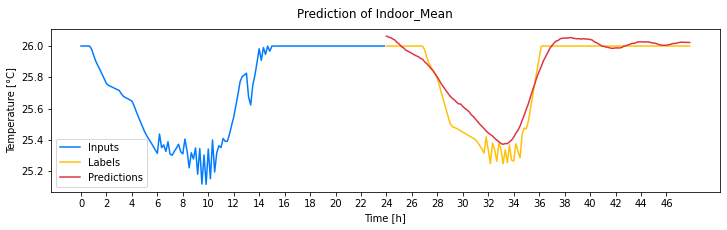

In [15]:
column_to_predict = 'Indoor_Mean'
w1 = WindowGenerator(input_width=6*24, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict],
                     mean = mean, std = std)
w1.plot(multi_lstm_model, plot_col = column_to_predict,max_subplots=1)

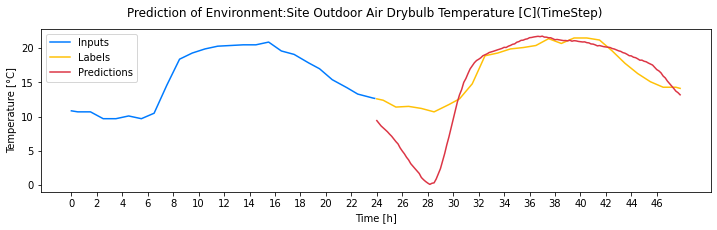

In [16]:
column_to_predict = 'Environment:Site Outdoor Air Drybulb Temperature [C](TimeStep)'
w1 = WindowGenerator(input_width=6*24, label_width=6*24, shift=6*24,
                     train_df=x_train_norm, val_df=x_val_norm, test_df=x_test_norm,
                     label_columns=[column_to_predict],
                     mean = mean, std = std)
w1.plot(multi_lstm_model, plot_col = column_to_predict,max_subplots=1)